In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
import statsmodels.formula.api as sm
import patsy
import itertools
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, auc
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, GridSearchCV,learning_curve
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer 
from sklearn.pipeline import Pipeline

In [3]:
job = pd.read_csv('data_job.csv')
job.shape

(3960, 9)

# EDA and Features Engineering

In [4]:
job.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 9 columns):
Unnamed: 0      3960 non-null int64
Job_Id          3960 non-null object
Job_Title       3960 non-null object
Company         3960 non-null object
Date_Posted     3960 non-null object
Salary          3960 non-null object
Seniority       3960 non-null object
Category        3960 non-null object
Requirements    3960 non-null object
dtypes: int64(1), object(8)
memory usage: 278.5+ KB


In [5]:
job.head()

,Unnamed: 0,Job_Id,Job_Title,Company,Date_Posted,Salary,Seniority,Category,Requirements
0,0,[b' JOB-2019-0090219 '],"[b'Data Engineer (5 days, Orchard, $3500-4000)']",[b'MACHSPEED HUMAN RESOURCES PTE. LTD.'],[b'Posted 27 Apr 2019'],"['/ $3,500to$4,000/ $3,500/ to$4,000/ Monthly/...",[b'Executive'],[b'Information Technology'],['RequirementsRequirements Minimum Degree/Dip...
1,1,[b' JOB-2019-0090314 '],[b'Customer Engagement Excellence Learning Man...,[b'BAYER (SOUTH EAST ASIA) PTE LTD'],[b'Posted 27 Apr 2019'],"['/ $10,400to$15,400/ $10,400/ to$15,400/ Mont...",[b'Manager'],[b'Healthcare / Pharmaceutical'],['Requirements A University / Bachelors degree...
2,2,[b' JOB-2019-0090256 '],"[b'Manager, Research']",[b'GROUP ONE HOLDINGS PTE. LTD.'],[b'Posted 27 Apr 2019'],"['/ $5,000to$8,000/ $5,000/ to$8,000/ Monthly/...",[b'Manager'],[b'Others'],['Requirements·\xa0\xa0\xa0\xa0\xa0\xa0\xa0A s...
3,3,[b' JOB-2019-0090319 '],"[b'Head of Research &amp; Evaluation, Asia']",[b'SAVE THE CHILDREN ASIA REGIONAL OFFICE LIMI...,[b'Posted 27 Apr 2019'],"['/ $80,000to$140,000/ $80,000/ to$140,000/ An...",[b'Middle Management'],[b'General Management'],['RequirementsQualifications 10 plus years ex...
4,4,[b' JOB-2019-0090300 '],[b'IT Systems Adminstrator'],[b'ELIXIR TECHNOLOGY PTE LTD'],[b'Posted 27 Apr 2019'],"['/ $2,800to$3,500/ $2,800/ to$3,500/ Monthly/...",[b'Professional'],[b'Information Technology'],"[""Requirements Bachelor's Degree in Computer S..."


In [6]:
job_clean = job.drop_duplicates(subset='Job_Id', keep='first') #remove duplicate based on Job ID

#drop job Id as it is only use to remove duplicates
job_clean = job_clean.drop(columns=['Job_Id','Unnamed: 0'])
job_clean.shape

(3932, 7)

In [7]:
#perform data cleaning on every row and columms
for col in job_clean.columns:
    job_clean[col]=job_clean[col].str.replace("(\[|\]|b'|Requirements|'|amp;|xa0|\\\|\|xe2x80x93)", "")
job_clean.head()

,Job_Title,Company,Date_Posted,Salary,Seniority,Category,Requirements
0,"Data Engineer (5 days, Orchard, $3500-4000)",MACHSPEED HUMAN RESOURCES PTE. LTD.,Posted 27 Apr 2019,"/ $3,500to$4,000/ $3,500/ to$4,000/ Monthly/ C...",Executive,Information Technology,"Minimum Degree/Diploma in Computer Science, ..."
1,Customer Engagement Excellence Learning Manager,BAYER (SOUTH EAST ASIA) PTE LTD,Posted 27 Apr 2019,"/ $10,400to$15,400/ $10,400/ to$15,400/ Monthl...",Manager,Healthcare / Pharmaceutical,A University / Bachelors degree holder in app...
2,"Manager, Research",GROUP ONE HOLDINGS PTE. LTD.,Posted 27 Apr 2019,"/ $5,000to$8,000/ $5,000/ to$8,000/ Monthly/ C...",Manager,Others,"·A smart communicator, a team player with proa..."
3,"Head of Research & Evaluation, Asia",SAVE THE CHILDREN ASIA REGIONAL OFFICE LIMITED,Posted 27 Apr 2019,"/ $80,000to$140,000/ $80,000/ to$140,000/ Annu...",Middle Management,General Management,Qualifications 10 plus years expertise and do...
4,IT Systems Adminstrator,ELIXIR TECHNOLOGY PTE LTD,Posted 27 Apr 2019,"/ $2,800to$3,500/ $2,800/ to$3,500/ Monthly/ C...",Professional,Information Technology,""" Bachelors Degree in Computer Science, Comput..."


In [8]:
#check for row with missing job title
job_clean[job_clean['Job_Title'] == '']

,Job_Title,Company,Date_Posted,Salary,Seniority,Category,Requirements
27,,,,,,,


In [9]:
empty = job_clean['Job_Title'] == ''

In [10]:
#remove row without job title
job_clean = job_clean[~empty]

In [11]:
#remove row without salary
no_salary = job_clean['Salary'].str.contains('Salary undisclosed')

In [12]:
job_clean_df = job_clean[~no_salary]

In [13]:
#extract salary columns due to contain multiple information
salary_range = job_clean_df["Salary"].str.split("/", n = 5, expand = True) 

In [14]:
salary_range.head()

,0,1,2,3,4,5
0,,"$3,500to$4,000","$3,500","to$4,000",Monthly,Closing on 27 May 2019
1,,"$10,400to$15,400","$10,400","to$15,400",Monthly,Closing on 12 May 2019
2,,"$5,000to$8,000","$5,000","to$8,000",Monthly,Closing on 27 May 2019
3,,"$80,000to$140,000","$80,000","to$140,000",Annually,Closing on 11 May 2019
4,,"$2,800to$3,500","$2,800","to$3,500",Monthly,Closing on 27 May 2019


In [15]:
#Give columns name to the dataframe
salary_range = salary_range.rename({0:'recruiter',1:'range', 2:'min', 3:'max', 4:'type'}, axis='columns')

In [16]:
#split the range column which contain min and max salary
min_max = salary_range['range'].str.split('to', n=2, expand = True)
min_max = min_max.rename({0:'sal_min', 1:'sal_max'}, axis='columns')

In [17]:
#concat min_max salary dataframe with salary range dataframe
salary_range = pd.concat([salary_range, min_max], axis=1)

In [18]:
salary_range.shape

(3472, 8)

In [19]:
#removed $ and 'to' from salary 
for col in salary_range.columns:
    salary_range[col]=salary_range[col].str.replace('(\$|,|to)', '')
salary_range.head()

,recruiter,range,min,max,type,5,sal_min,sal_max
0,,35004000,3500,4000,Monthly,Closing on 27 May 2019,3500,4000
1,,1040015400,10400,15400,Monthly,Closing on 12 May 2019,10400,15400
2,,50008000,5000,8000,Monthly,Closing on 27 May 2019,5000,8000
3,,80000140000,80000,140000,Annually,Closing on 11 May 2019,80000,140000
4,,28003500,2800,3500,Monthly,Closing on 27 May 2019,2800,3500


In [20]:
#data from job posted by recruiter are shifted to the right
#salary min falls under max and salary max falls under type
salary_range[salary_range['recruiter'].str.contains('Recruiter')].head()

,recruiter,range,min,max,type,5,sal_min,sal_max
53,via Recruiter,,25003200,2500,3200,Monthly/ Closing on 26 May 2019,,None
72,Recruiter,,30005000,3000,5000,Monthly/ Closing on 26 May 2019,,None
96,via Recruiter,,18002600,1800,2600,Monthly/ Closing on 26 May 2019,,None
99,via Recruiter,,63006800,6300,6800,Monthly/ Closing on 26 May 2019,,None
103,via Recruiter,,780012200,7800,12200,Monthly/ Closing on 10 May 2019,,None


In [21]:
#adjust salary min and max location for recruiter data
salary_range.loc[salary_range['recruiter'].str.contains('Recruiter'), 'sal_min'] = salary_range['max']
salary_range.loc[salary_range['recruiter'].str.contains('Recruiter'), 'sal_max'] = salary_range['type']

In [22]:
#convert from ojbect to float for statistical infomation
salary_range['sal_min'] = salary_range['sal_min'].astype('float64')
salary_range['sal_max'] = salary_range['sal_max'].astype('float64')

In [23]:
#from the min and max value, extream outliers were observed
salary_range.describe()

,sal_min,sal_max
count,3472.000000,3472.000000
mean,7215.020449,11079.663882
std,15684.739939,23760.781468
min,1.000000,2.000000
25%,2800.000000,4000.000000
50%,4100.000000,6800.000000
75%,6500.000000,10000.000000
max,280000.000000,405000.000000


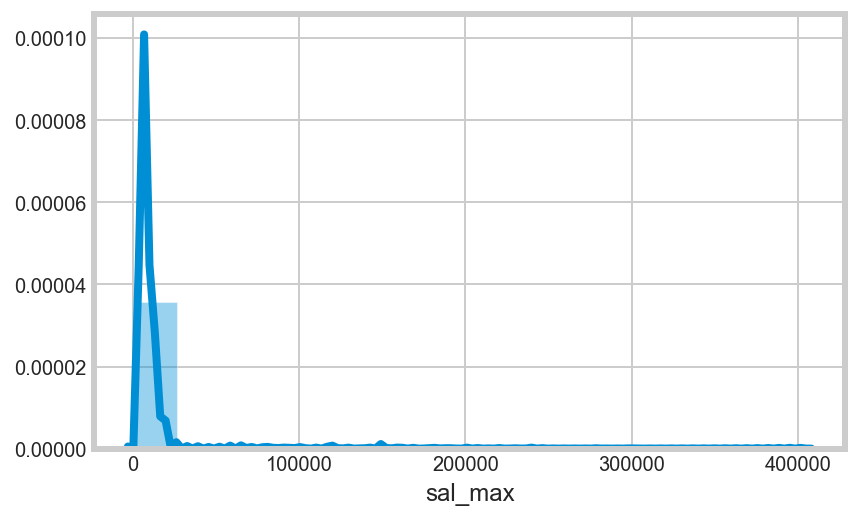

In [31]:
sns.distplot(salary_range['sal_max'],bins=15)

From the plot, outliers caused the salary distribution to be heavily skewed

In [32]:
#create a condition to check for high outliers
abovemean = 3*np.mean(salary_range['sal_min'])

In [33]:
#found salary which is 3 times higher than mean are actually Annual salary
salary_range[((salary_range['recruiter'].str.contains('Recruiter')) & (salary_range['sal_min'] > abovemean))]

,recruiter,type,sal_min,sal_max
428,Recruiter,180000,110000.0,180000.0
1859,Recruiter,80000,70000.0,80000.0


In [34]:
#Rename salary type accordingly based on salary
salary_range.loc[((salary_range['recruiter'].str.contains('Recruiter')) & (salary_range['sal_min'] > abovemean)), 'type'] = ' Annually'
salary_range.loc[((salary_range['recruiter'].str.contains('Recruiter')) & (salary_range['sal_min'] < abovemean)), 'type'] = ' Monthly'

In [35]:
#only keep relevent columns before merge back
salary_range = salary_range.drop(columns=['range','min','max',5])

KeyError: "['range' 'min' 'max' 5] not found in axis"

In [36]:
#concat back to orginal dataframe after feature engineering completed for salary columns
job_df = pd.concat([job_clean_df, salary_range], axis=1)

In [37]:
#drop original salary columns and date posted due to feature not useful for prediction
job_df = job_df.drop(columns=['Date_Posted','Salary','recruiter'])

In [38]:
#detected 5 jobs with unrealistic min and max monthly salary range (which is more than 10 times)
job_df.loc[(job_df['sal_max']>10*job_df['sal_min'])]

,Job_Title,Company,Seniority,Category,Requirements,type,sal_min,sal_max
809,Assistant Manager / Manager,SAMSUNG SDS ASIA PACIFIC PTE. LTD.,Senior Executive,Others,""" Bachelors degree in Mathematics, Computer Sc...",Monthly,5000.0,70000.0
1650,Sr Sitecore Developer,GATEWAY SEARCH PTE. LTD.,Senior Executive,Information Technology,"2 years’ experience in designing, developing,...",Monthly,5000.0,75000.0
1860,Technical Consultant,RANDSTAD PTE. LIMITED,Senior Executive,Information Technology,: • Degree in Information Technology or relat...,Monthly,7000.0,100000.0
3171,Front-End Developer,STANDARD CHARTERED BANK,Manager,"Banking and Finance, Information Technology",Ideal Candidate: The successful candidate is e...,Monthly,10000.0,190000.0
3553,Software engineer,Company Undisclosed,"Executive, Senior Executive",Information Technology,WHAT YOU’LL NEED: Strong CS fundamentals (wit...,Monthly,4000.0,85000.0


In [39]:
#assuming typo for sal_max 10 times more than sal_min. To correct value by sal_max divided by 10
job_df.loc[(job_df['sal_max']>10*job_df['sal_min']), 'sal_max'] = job_df['sal_max']/10

In [40]:
#standardize all salary type to Monthly
job_df.loc[job_df['type'].str.contains(' Annually'), 'sal_min'] = round(job_df['sal_min']/12)
job_df.loc[job_df['type'].str.contains(' Annually'), 'sal_max'] = round(job_df['sal_max']/12)
job_df = job_df.drop(columns='type')

In [41]:
#further remove job with same data from all columns
job_df = job_df.drop_duplicates(subset=job_df.columns, keep='first')

In [42]:
#further filter on job title with specific keywords
title_key = ['DATA', 'MACHINE','ANALYST','MACHINE LEARNING','ANALYTICS','DEEP LEARNING','RESEARCH','NLP']
key = '|'.join(title_key)
data_job = job_df['Job_Title'].str.upper().str.contains(key)
job_df = job_df[data_job]

In [43]:
#to drop job with max salary less than 2000, assuming data entry/admin/operator job
mask_low = job_df['sal_max']<=2000
job_df = job_df[~mask_low]

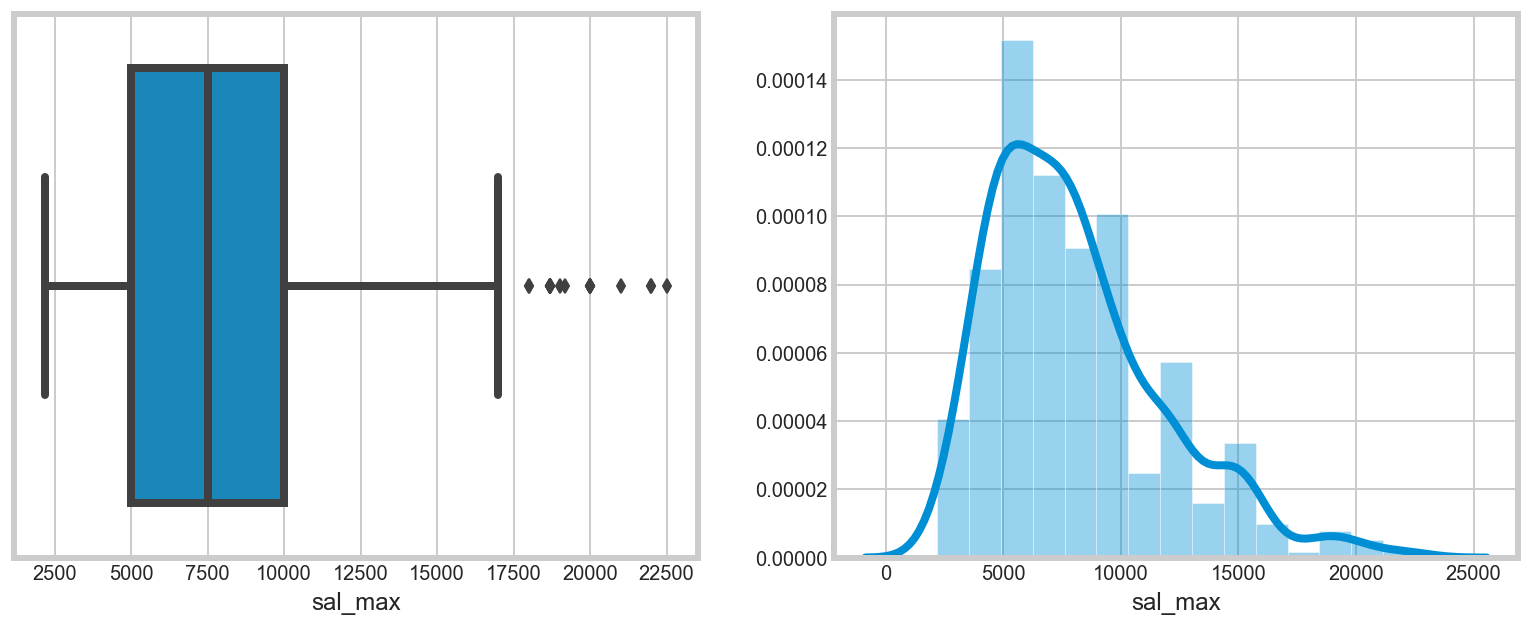

In [44]:
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(12,5))
sns.boxplot(job_df['sal_max'], ax=ax[0])
sns.distplot(job_df['sal_max'],bins=15, ax=ax[1])

After few extream outliers were removed, median for sal_max is around $7500 but there are still few job with very high monthly salary

In [45]:
job_df[job_df['sal_max']>17500].groupby(['Company', 'Seniority']).count()

Job_Title  \
Company                                       Seniority                                
CISCO SYSTEMS (USA) PTE. LTD.                 Professional                         1   
Company Undisclosed                           Senior Management                    2   
DBS BANK LTD.                                 Middle Management                    1   
                                              Senior Management                    7   
DEUTSCHE BANK AKTIENGESELLSCHAFT              Professional                         1   
GOOGLE ASIA PACIFIC PTE. LTD.                 Executive                            3   
MARKS SATTIN (SINGAPORE) PTE. LIMITED         Executive                            1   
MERGERMARKET CONSULTING (SINGAPORE) PTE. LTD. Executive, Senior Executive          1   
RIO TINTO COMMERCIAL PTE. LTD.                Professional                         2   
STANDARD CHARTERED BANK                       Middle Management, Manager           1   

                                                                           Category  \
Company                                       Seniority                               
CISCO SYSTEMS (USA) PTE. LTD.                 Professional                        1   
Company Undisclosed                           Senior Management                   2   
DBS BANK LTD.                                 Middle Management                   1   
                                              Senior Management                   7   
DEUTSCHE BANK AKTIENGESELLSCHAFT              Professional                        1   
GOOGLE ASIA PACIFIC PTE. LTD.                 Executive                           3   
MARKS SATTIN (SINGAPORE) PTE. LIMITED         Executive                           1   
MERGERMARKET CONSULTING (SINGAPORE) PTE. LTD. Executive, Senior Executive         1   
RIO TINTO COMMERCIAL PTE. LTD.                Professional                        2   
STANDARD CHARTERED BANK                       Middle Management, Manager          1   

                                                                           Requirements  \
Company                                       Seniority                                   
CISCO SYSTEMS (USA) PTE. LTD.                 Professional                            1   
Company Undisclosed                           Senior Management                       2   
DBS BANK LTD.                                 Middle Management                       1   
                                              Senior Management                       7   
DEUTSCHE BANK AKTIENGESELLSCHAFT              Professional                            1   
GOOGLE ASIA PACIFIC PTE. LTD.                 Executive                               3   
MARKS SATTIN (SINGAPORE) PTE. LIMITED         Executive                               1   
MERGERMARKET CONSULTING (SINGAPORE) PTE. LTD. Executive, Senior Executive             1   
RIO TINTO COMMERCIAL PTE. LTD.                Professional                            2   
STANDARD CHARTERED BANK                       Middle Management, Manager              1   

                                                                           sal_min  \
Company                                       Seniority                              
CISCO SYSTEMS (USA) PTE. LTD.                 Professional                       1   
Company Undisclosed                           Senior Management                  2   
DBS BANK LTD.                                 Middle Management                  1   
                                              Senior Management                  7   
DEUTSCHE BANK AKTIENGESELLSCHAFT              Professional                       1   
GOOGLE ASIA PACIFIC PTE. LTD.                 Executive                          3   
MARKS SATTIN (SINGAPORE) PTE. LIMITED         Executive                          1   
MERGERMARKET CONSULTING (SINGAPORE) PTE. LTD. Executive, Senior Executive        1   
RIO TINTO COMMERCIAL

Jobs with high salary are mainy from higher management level, banking/finance industry, well-known MNC such as Google and CISCO. Hence, will keep in the dataset

In [46]:
#create new feature for average salary
job_df['Avg Salary'] = (job_df['sal_min'] + job_df['sal_max']) / 2

In [47]:
job_df['Avg Salary'].describe()

count      838.000000
mean      6618.238663
std       2950.465273
min       2000.000000
25%       4258.375000
50%       6000.000000
75%       8000.000000
max      21750.000000
Name: Avg Salary, dtype: float64

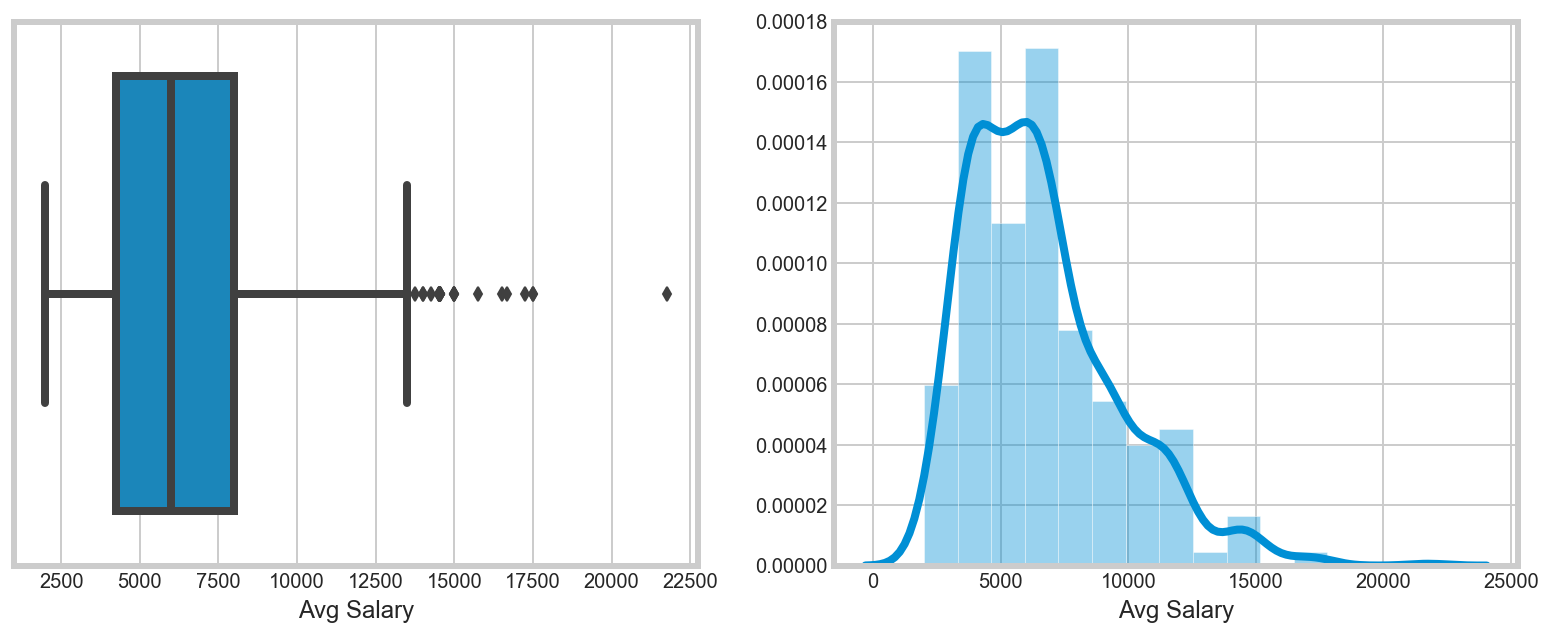

In [48]:
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(12,5))
sns.boxplot(job_df['Avg Salary'], ax=ax[0])
sns.distplot(job_df['Avg Salary'],bins=15, ax=ax[1])

Average monthly salary column was created for labeling purpose for next step. The mean value at $6600 for the average salary and median at 6000, which in Singapore is consider as high pay.
Next label was created for high and low salary according to median salary.

In [49]:
#Labeled 1 for salary above median (high) and 0 for salary below median (low)
job_df["sal_high"] = job_df['Avg Salary'].map(lambda x: 1 if x >= np.median(job_df['Avg Salary']) else 0)
job_df["sal_high"].value_counts()

1    450
0    388
Name: sal_high, dtype: int64

In [50]:
#baseline model at 53% due to salary cut-off at median
baseline = np.mean(job_df["sal_high"])
baseline

0.5369928400954654

In [51]:
job_df = job_df.reset_index(drop=True)

In [52]:
#check seniority with multiple rank
job_df[job_df['Seniority'].str.count(',')>=2].head()

,Job_Title,Company,Seniority,Category,Requirements,sal_min,sal_max,Avg Salary,sal_high
54,Senior / Reporting Analyst,SIVANTOS PTE. LTD.,"Executive, Junior Executive, Senior Executive",Logistics / Supply Chain,The successful candidate will be an individual...,3500.0,5500.0,4500.0,0
63,Data Migration Lead,Company Undisclosed,"Manager, Professional, Senior Executive",Information Technology,"""The Successful Applicant Must have relevant ...",7000.0,10000.0,8500.0,1
70,Data Engineer,FRIARTUCK PTE LTD,"Professional, Executive, Senior Executive","Consulting , Information Technology","""Responsibilities Build the infrastructure an...",6000.0,8000.0,7000.0,1
84,Analyst,AON HEWITT SINGAPORE PTE. LTD.,"Executive, Junior Executive, Senior Executive",Consulting,"Bachelor’s Degree in Business Administration,...",3000.0,4000.0,3500.0,0
139,Project Analyst,INDEPENDENT PROJECT ANALYSIS PRIVATE LIMITED,"Manager, Professional, Senior Executive","Consulting , Professional Services",*Strong quantitative analytical skill/ Underst...,6000.0,10000.0,8000.0,1


In [53]:
job_df['Seniority'] = job_df['Seniority'].str.split(', ')

In [54]:
#for job more with multiple seniority, only one will be taken as reference after the split
job_df['Seniority'] = job_df['Seniority'].map(lambda x: x[0] if len(x)>2 else (x[1] if len(x)>1 else x[0]))

In [55]:
job_df['Seniority'].value_counts()

Professional         233
Executive            198
Senior Executive     109
Non-executive         79
Manager               60
Junior Executive      54
Fresh/entry level     41
Middle Management     38
Senior Management     26
Name: Seniority, dtype: int64

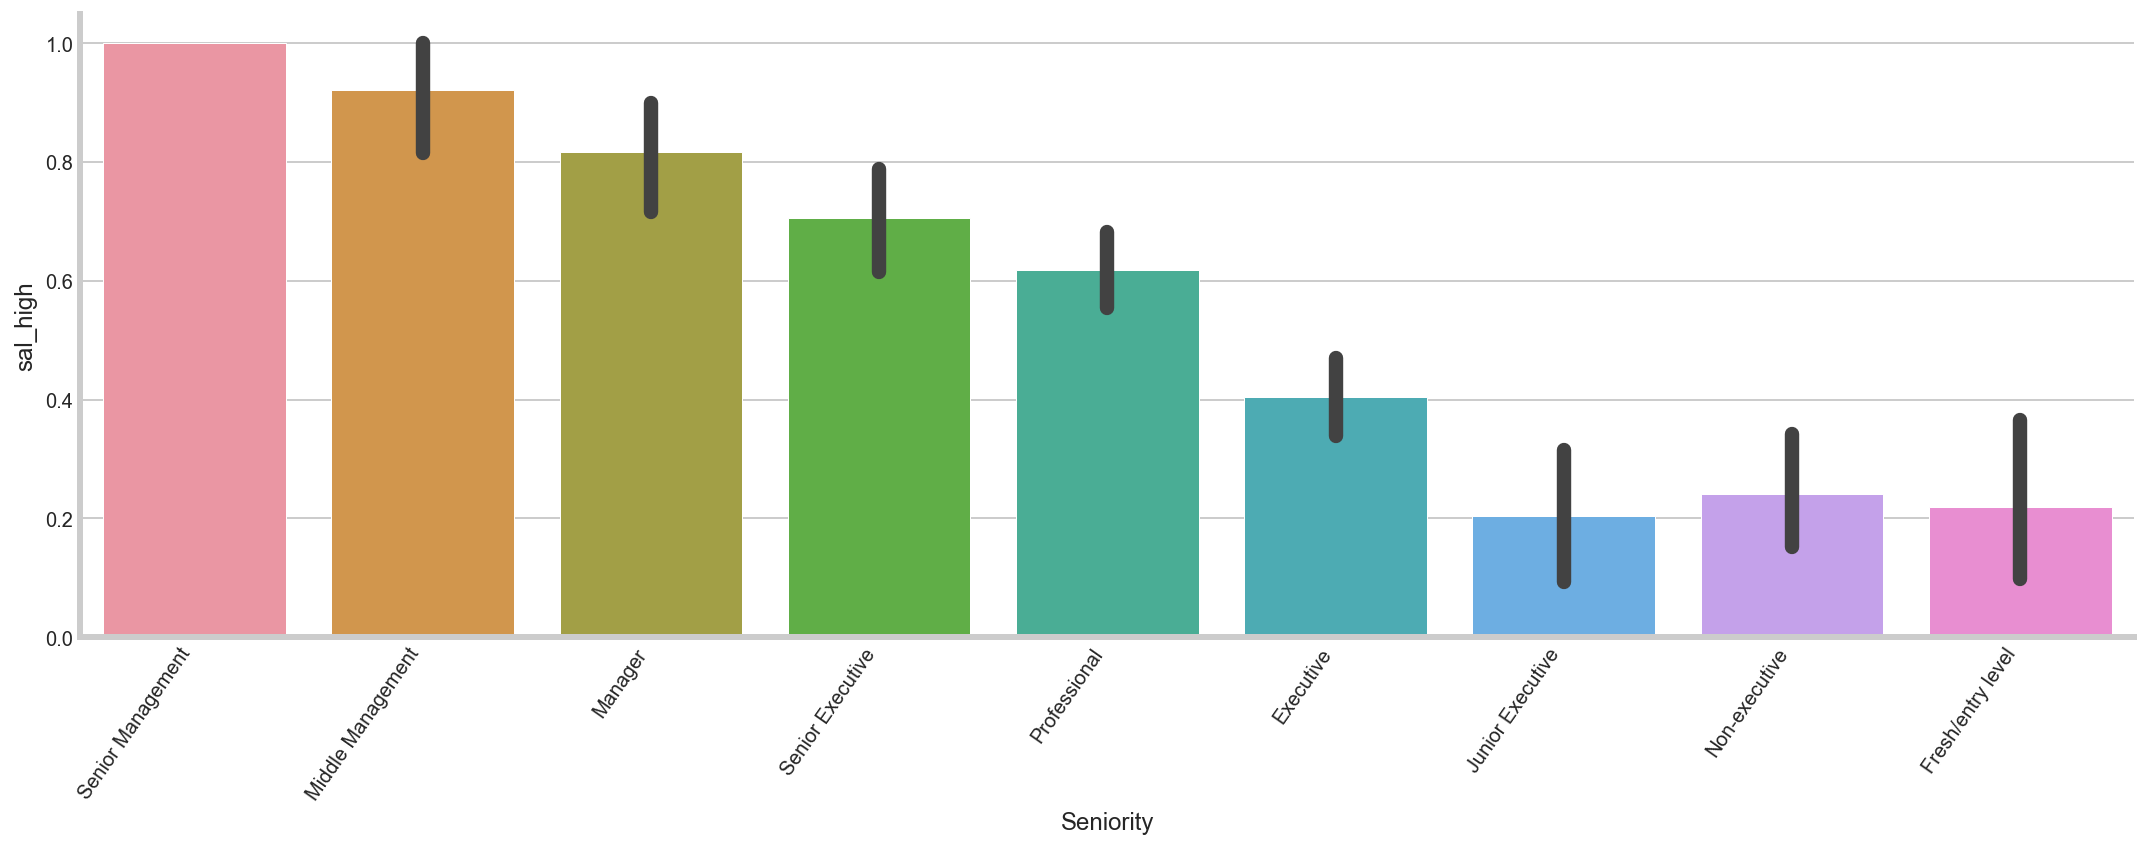

In [56]:
senior_order = ('Senior Management', 'Middle Management', 'Manager','Senior Executive',
                'Professional','Executive', 'Junior Executive','Non-executive','Fresh/entry level')

sns.catplot(x='Seniority', y='sal_high',data=job_df, kind='bar', aspect=3, 
               order=senior_order).set_xticklabels(rotation=55, horizontalalignment='right')
plt.show();

From the plot, seniority can be a good predictor for high and low salary. Junior executive can be considered as fresh/entry level too for most of the companies. Non-executive was slightly above both Junior role and entry level due to job without executive level was mostly likely to classify as non-executive.

In [57]:
#Dummified Seniority columns to use as predictor features
seniority_cat=job_df['Seniority'].str.get_dummies()
seniority_cat.head()

,Executive,Fresh/entry level,Junior Executive,Manager,Middle Management,Non-executive,Professional,Senior Executive,Senior Management
0,1,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,1,0,0


In [58]:
job_df = pd.concat([job_df, seniority_cat], axis=1)

# QUESTION 1: Factors that impact salary

In [59]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import stop_words
from nltk.corpus import stopwords

In [60]:
#stop words were added to filter some generic recurring business terms.
stop = stopwords.words('english')
stop += ['regret','shortlisted', 'candidates','notified','etc', 'take', 'hands']

In [61]:
def freq_words(word_count, features):

    num_word = np.asarray(word_count.sum(axis=0)).reshape(-1)
    most_count = num_word.argsort()[::-1]
    key_word = pd.Series(num_word[most_count], 
                           index=features[most_count])

    return key_word

In [62]:
#most common words for requirements
cvt      =  CountVectorizer(lowercase=True, strip_accents='unicode',
                       max_features=1500, min_df=5, max_df=0.7,
                       stop_words=stop, ngram_range=(1,2))
vect_word    =  cvt.fit_transform(job_df['Requirements'])
features  =  np.array(cvt.get_feature_names()) 

key_word = freq_words(vect_word, features)
key_word[:20]

data             1637
skills           1268
knowledge         719
ability           692
strong            681
years             593
work              567
business          522
management        511
working           496
good              486
degree            477
science           442
computer          422
communication     417
team              410
excellent         364
sql               328
related           318
learning          317
dtype: int64

Checking keyword with countvetorizer with number of features set to 1500, minimun appearance of 5 times from different row and maximum apperance of not more than 70% in the overall dataset. Common word for data related job such as data, skills, knowledge, ability still can be observed after the setting the parameters.

In [63]:
#most common ngrams for requirements
cvt = CountVectorizer(lowercase=True, strip_accents='unicode',
                       max_features=1500, min_df=5, max_df=0.7,
                       stop_words=stop, ngram_range=(2,2))
vect_word = cvt.fit_transform(job_df['Requirements'])
features  =  np.array(cvt.get_feature_names())

key_word = freq_words(vect_word, features)
key_word[:10]

computer science        291
communication skills    267
years experience        224
machine learning        201
problem solving         168
ability work            157
big data                149
experience working      143
skills ability          142
team player             130
dtype: int64

Limit ngram to 2, data science related keywords can be observed such as machine learning, big data and computer science

In [64]:
tfid = TfidfVectorizer(lowercase=True, strip_accents='unicode',
                       max_features=1500, min_df=5, max_df=0.7,
                       stop_words=stop, ngram_range=(2,2))
tfid_word = tfid.fit_transform(job_df['Requirements'])
features  =  np.array(tfid.get_feature_names())

key_word = freq_words(tfid_word, features)
key_word[:10]

communication skills    25.591916
computer science        25.538059
years experience        22.934461
machine learning        21.423508
least years             17.625518
problem solving         17.451751
ability work            17.350427
experience working      16.833215
team player             16.443906
big data                15.745155
dtype: float64

Tried with TFID vectorizer on ngam=2 but result shows no siginifiant different from Count vectorizer, hence for the modeling will just stick with Count Vectorizer

In [65]:
#CountVectorizer job requirements columns
cvec = CountVectorizer(lowercase=True, strip_accents='unicode',
                       max_features=1500, min_df=5, max_df=0.7, 
                       stop_words=stop,ngram_range=(1,2))
cvec.fit(job_df['Requirements'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.7, max_features=1500, min_df=5,
        ngram_range=(1, 2), preprocessor=None,
        stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',...t", 'wouldn', "wouldn't", 'regret', 'shortlisted', 'candidates', 'notified', 'etc', 'take', 'hands'],
        strip_accents='unicode', token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [66]:
#creating predictor and target dataset
model_data = job_df.drop(columns=['Job_Title','Company','Seniority','Category','sal_min','sal_max','Avg Salary'])

nlp = pd.DataFrame(cvec.transform(model_data['Requirements']).todense(),columns=cvec.get_feature_names())

senior_nlp = pd.concat([model_data, nlp], axis=1)
senior_nlp.shape

(838, 1511)

In [67]:
X = senior_nlp.drop(columns=['sal_high','Requirements'])
X_nlp = nlp
y = senior_nlp['sal_high'].values

In [68]:
#Data with dummified 'seniority' and countvectorized 'requirements'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [69]:
#Data with countvectorized 'requirements' only
X_train_nlp, X_test_nlp, y_train_nlp, y_test_nlp = train_test_split(X_nlp, y, test_size=0.2, random_state=42)

### Choosing the best model (Logistic, AdaBoost or RandomForest)

In [70]:
#Logistic regression model
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
print('CV score on NLP+Seniority dummy data:', np.mean(cross_val_score(lr, X_train, y_train, cv=5, scoring='roc_auc')))
print('CV score on NLP data:', np.mean(cross_val_score(lr, X_train_nlp, y_train_nlp, cv=5, scoring='roc_auc')))

CV score on NLP+Seniority dummy data: 0.787587582444087
CV score on NLP data: 0.7702642477725774


In [71]:
#Adaboost model
from sklearn.ensemble import AdaBoostClassifier
Ada = AdaBoostClassifier()
Ada.fit(X_train, y_train)
print('CV score on NLP+Seniority dummy data:', np.mean(cross_val_score(Ada, X_train, y_train, cv=5, scoring='roc_auc')))
print('CV score on NLP data:', np.mean(cross_val_score(Ada, X_train_nlp, y_train_nlp, cv=5, scoring='roc_auc')))

CV score on NLP+Seniority dummy data: 0.7909851482451058
CV score on NLP data: 0.7431006288627824


In [72]:
#RandomForest model
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(random_state=42)
rfc.fit(X_train,y_train)
print('CV score on NLP+Seniority dummy data:', np.mean(cross_val_score(rfc, X_train, y_train, cv=5, scoring='roc_auc')))
print('CV score on NLP data:', np.mean(cross_val_score(rfc, X_train_nlp, y_train_nlp, cv=5, scoring='roc_auc')))

CV score on NLP+Seniority dummy data: 0.7550960882779754
CV score on NLP data: 0.7523778773797705


Data consists of dummified seniority plus CountVectorized requirements provide better cross val score across all models. Logistic regression model performed better in cross val score compare to ensemble models (AdaBoost and RandomForest).

### Logistic regression model with hyperparameter tune and classfication report

In [73]:
#hyperparameter tune for logistic regression
lr_params = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}
gs_lr = GridSearchCV(lr, param_grid=lr_params, cv=5, scoring='roc_auc', n_jobs=-1)
gs_lr.fit(X_train,y_train)

lr_c2=gs_lr.best_estimator_
lr_c2.fit(X_train,y_train)

print('CV score on train data:', np.mean(cross_val_score(lr_c2, X_train, y_train, cv=5, scoring='roc_auc')))
print('CV score on test data:', np.mean(cross_val_score(lr_c2, X_test, y_test, cv=5, scoring='roc_auc')))

CV score on train data: 0.7960960806655947
CV score on test data: 0.7702534113060429


In [74]:
pd.DataFrame(confusion_matrix(y_test,lr_c2.predict(X_test)),
             index=['Actual Low Salary','Actual High Salary'],
             columns=['Predicted Low Salary','Predicted High Salary'])

,Predicted Low Salary,Predicted High Salary
Actual Low Salary,52,23
Actual High Salary,24,69


In [75]:
print(classification_report(y_test,lr_c2.predict(X_test),target_names=["Low Salary", "High Salary"]))

              precision    recall  f1-score   support

  Low Salary       0.68      0.69      0.69        75
 High Salary       0.75      0.74      0.75        93

   micro avg       0.72      0.72      0.72       168
   macro avg       0.72      0.72      0.72       168
weighted avg       0.72      0.72      0.72       168



Both class under train/test data are balance, so AUC score was chosen as valuation parameter. In overall the model is able to predict better than the baseline.
Recall for low salary indicates 23 out of 75 low salary jobs are predicted as high salary which is the major concern for bonus question. This will be handled in the next part.

In [85]:
features = np.array(X_train.columns)
lr_coefs = pd.DataFrame({'coef':lr_c2.coef_[0], 'abs coef':abs(lr_c2.coef_[0])},index=features)
lr_coefs = lr_coefs.sort_values('coef',ascending=False)
lr_coefs.head(5)

,coef,abs coef
phd,0.436951,0.436951
work experience,0.333218,0.333218
modeling,0.319042,0.319042
Manager,0.315336,0.315336
hadoop,0.312095,0.312095


In [86]:
lr_coefs.tail(5)

,coef,abs coef
Non-executive,-0.373823,0.373823
sciences,-0.382525,0.382525
Junior Executive,-0.388593,0.388593
Executive,-0.420766,0.420766
diploma,-0.432527,0.432527


Logisitic regression model is able to provide both positive and negative coefficient, which allow us to find out features that contribute to high salary and low salary as well.
From the features, apart from seniority level, education level such as phD holder vs diploma, work experience and skill such as hadoop have a direct impact on the salary.

### Random Forest model with hyperparameter tune and classfication report

In [92]:
rfc_params={
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'n_estimators': [50,100,150,200]}

gs_rfc=GridSearchCV(rfc, rfc_params, cv=5, scoring='roc_auc', n_jobs=-1)
gs_rfc.fit(X_train,y_train)

rfc2=gs_rfc.best_estimator_
rfc2.fit(X_train,y_train)

print('CV score on train data:', np.mean(cross_val_score(rfc2, X_train, y_train, cv=5, scoring='roc_auc')))
print('CV score on test data:', np.mean(cross_val_score(rfc2, X_test, y_test, cv=5, scoring='roc_auc')))

CV score on train data: 0.8166269320422735
CV score on test data: 0.7375438596491228


In [93]:
pd.DataFrame(confusion_matrix(y_test,rfc2.predict(X_test)),
             index=['Actual Low Salary','Actual High Salary'],
             columns=['Predicted Low Salary','Predicted High Salary'])

,Predicted Low Salary,Predicted High Salary
Actual Low Salary,54,21
Actual High Salary,20,73


In [94]:
print(classification_report(y_test,rfc2.predict(X_test),target_names=["Low Salary", "High Salary"]))

              precision    recall  f1-score   support

  Low Salary       0.73      0.72      0.72        75
 High Salary       0.78      0.78      0.78        93

   micro avg       0.76      0.76      0.76       168
   macro avg       0.75      0.75      0.75       168
weighted avg       0.76      0.76      0.76       168



From the test data cross val score, random forest is slightly lower compare to logistic regression but higher precision and recall score

In [90]:
features = np.array(X_train.columns)
rf_coefs = pd.DataFrame({'coef':rfc2.feature_importances_},index=features)
rf_coefs.sort_values('coef',ascending = False).head(10)

,coef
diploma,0.015199
Executive,0.009360
hadoop,0.008942
modeling,0.008766
understanding,0.007481
across,0.007439
Senior Management,0.007384
Junior Executive,0.007347
Middle Management,0.007292
salary,0.006621


Random Forest model importance feature also indicates certain features which appeared in logisitic regression model such as diploma, hadoop, modeling and seniority level

### AdaBoost model with hyperparameter tune and classfication report

In [95]:
ada_params = {'n_estimators' : [50,100,150,200,250,500],'learning_rate' : [.5,.75,1.0,1.25,1.5,1.75,2.0]}
gs_ada = GridSearchCV(Ada, param_grid=ada_params, cv=5, scoring='roc_auc', n_jobs=-1)
gs_ada.fit(X_train,y_train)

ada_c2=gs_ada.best_estimator_
ada_c2.fit(X_train,y_train)

print('CV score on train data:', np.mean(cross_val_score(ada_c2, X_train, y_train, cv=5, scoring='roc_auc')))
print('CV score on test data:', np.mean(cross_val_score(ada_c2, X_test, y_test, cv=5, scoring='roc_auc')))

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CV score on train data: 0.7983762891967495
CV score on test data: 0.7410526315789474


In [96]:
pd.DataFrame(confusion_matrix(y_test,ada_c2.predict(X_test)),
             index=['Actual Low Salary','Actual High Salary'],
             columns=['Predicted Low Salary','Predicted High Salary'])

,Predicted Low Salary,Predicted High Salary
Actual Low Salary,58,17
Actual High Salary,22,71


In [97]:
print(classification_report(y_test,ada_c2.predict(X_test),target_names=["Low Salary", "High Salary"]))

              precision    recall  f1-score   support

  Low Salary       0.72      0.77      0.75        75
 High Salary       0.81      0.76      0.78        93

   micro avg       0.77      0.77      0.77       168
   macro avg       0.77      0.77      0.77       168
weighted avg       0.77      0.77      0.77       168



Adaboost test data cross val score ranked second but with the highest precision and recall score among all

In [100]:
features = np.array(X_train.columns)
ada_coefs = pd.DataFrame({'coef':ada_c2.feature_importances_},index=features)
ada_coefs.sort_values('coef',ascending = False).head(10)

,coef
Non-executive,0.020
Middle Management,0.018
Professional,0.016
phd,0.014
command,0.012
sciences,0.012
projects,0.012
minimum bachelor,0.010
integration,0.010
Fresh/entry level,0.010


With no suprise that seniority play a big part as predictor, phD is being captured by Adaboost as one of the top predictor which is the same as logisitic regression model

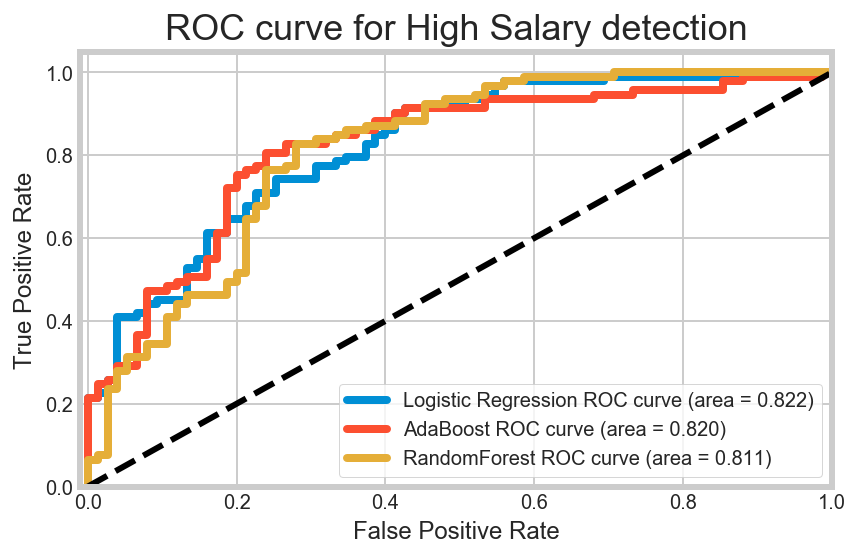

In [101]:
#ROC curve and AUC score for all 3 models

y_score_lr = lr_c2.predict_proba(X_test)[:,1]
y_score_ada = ada_c2.predict_proba(X_test)[:,1]
y_score_rf = rfc2.predict_proba(X_test)[:,1]

FPR1, TPR1, THR1 = roc_curve(y_test,y_score_lr)
FPR2, TPR2, THR2 = roc_curve(y_test,y_score_ada)
FPR3, TPR3, THR3 = roc_curve(y_test,y_score_rf)
ROC_AUC1=auc(FPR1,TPR1)
ROC_AUC2=auc(FPR2,TPR2)
ROC_AUC3=auc(FPR3,TPR3)

plt.plot(FPR1, TPR1, label='Logistic Regression ROC curve (area = %0.3f)' % ROC_AUC1, linewidth=4)
plt.plot(FPR2, TPR2, label='AdaBoost ROC curve (area = %0.3f)' % ROC_AUC2, linewidth=4)
plt.plot(FPR3, TPR3, label='RandomForest ROC curve (area = %0.3f)' % ROC_AUC3, linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', linewidth=3)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC curve for High Salary detection', fontsize=18)
plt.legend(loc="lower right")
plt.show()

Based on AUC score, logistic regression is the highest among 3 models but Adaboost model turn out to have higher precision and recall score which is better for prediction. Logistic regression on the other hand is able to provide positive and negative coeffient which is important to determine which features contribute to higher salary.

In [104]:
#Top 10 features from all 3 models
Ada_feat = ada_coefs.sort_values('coef',ascending = False).head(10).index
Logit_reg = lr_coefs.sort_values('abs coef',ascending=False).head(10).index
rf_feat = rf_coefs.sort_values('coef',ascending = False).head(10).index

sal_features = pd.DataFrame({'AdaBoost model':Ada_feat, 'Logistic model':Logit_reg, 'Random Forest':rf_feat})
sal_features

,AdaBoost model,Logistic model,Random Forest
0,Non-executive,phd,diploma
1,Middle Management,diploma,Executive
2,Professional,Executive,hadoop
3,phd,Junior Executive,modeling
4,command,sciences,understanding
5,sciences,Non-executive,across
6,projects,Fresh/entry level,Senior Management
7,minimum bachelor,statistical,Junior Executive
8,integration,engineering,Middle Management
9,Fresh/entry level,work experience,salary


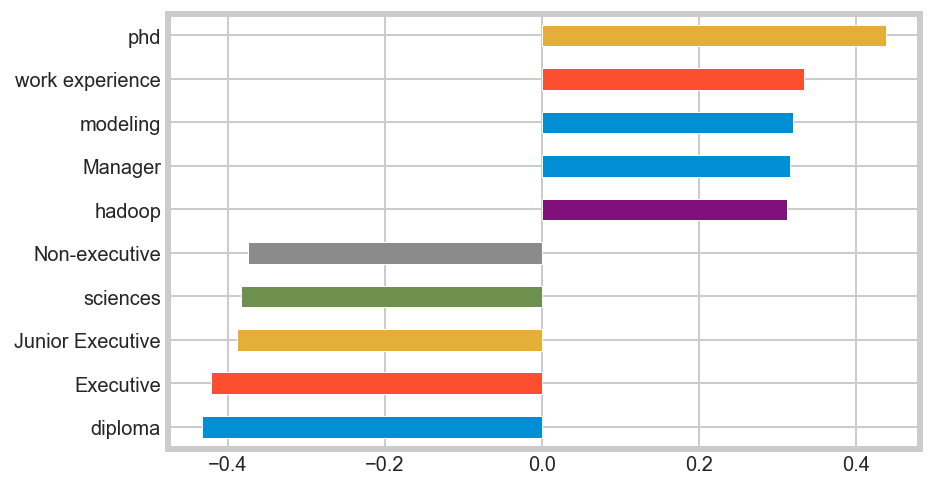

In [84]:
#Positive and negative coefficient chart from logistic regression model
imp_coefs = pd.concat([lr_coefs.sort_values('coef',ascending = True).head(5),
                     lr_coefs.sort_values('coef',ascending = True).tail(5)])
imp_coefs['coef'].plot(kind = "barh")

## Question 1 conclusion

### Factos that impact salary:

1) In conclusion, all 3 models AUC are better than baseline

2) Logistic regression model topped the AUC score but Adaboost has better precision and recall score. Logistic regression model is able to provide better insight due to positive and negative coefficient.

3) Top 5 job requirements which have positive coefficient for higher salary are PhD, managerial level, modeling skill, knowledge in Hadoop and work experience is a must.

4) Top 5 job requirements which have negative coefficient on the salary are diploma, seniority level which is below management and senior executive

5) We can conclude that seniority below or above managerial level is one of the main factor for salary above or below median. Other than seniority, education level and specific skills also contribute certain weightage on salary.

### BONUS PROBLEM

Your boss would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job. Adjust one of your models to ease his mind, and explain what it is doing and any tradeoffs. Plot the ROC curve.

In [105]:
pd.DataFrame(confusion_matrix(y_test,ada_c2.predict(X_test)),
             index=['Actual Low Salary','Actual High Salary'],
             columns=['Predicted Low Salary','Predicted High Salary'])

,Predicted Low Salary,Predicted High Salary
Actual Low Salary,58,17
Actual High Salary,22,71


In [106]:
print(classification_report(y_test,ada_c2.predict(X_test),target_names=["Low Salary", "High Salary"]))

              precision    recall  f1-score   support

  Low Salary       0.72      0.77      0.75        75
 High Salary       0.81      0.76      0.78        93

   micro avg       0.77      0.77      0.77       168
   macro avg       0.77      0.77      0.77       168
weighted avg       0.77      0.77      0.77       168



For this problem, AdaBoost model is selected for high precision and recall score. In this care, we will try to increase the recall score for low salary (means less false positive)

In [ ]:
#ROC curve and AUC score for all 3 models


y_score_ada = ada_c2.predict_proba(X_test)[:,1]


#FPR1, TPR1, THR1 = roc_curve(y_test,y_score_lr)
FPR2, TPR2, THR2 = roc_curve(y_test,y_score_ada)

#ROC_AUC1=auc(FPR1,TPR1)
ROC_AUC2=auc(FPR2,TPR2)

#plt.plot(FPR2, TPR2, label='ROC curve after adjustment (area = %0.3f)' % ROC_AUC2, linewidth=4)
plt.plot(FPR2, TPR2, label='ROC curve before adjustment(area = %0.3f)' % ROC_AUC2, linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', linewidth=3)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC curve for High Salary detection', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [107]:
#re-predict y based on threshold value given
def re_predict (y, threshold):
        if y > threshold:
            return 1
        else:
            return 0

In [111]:
pred_y = ada_c2.predict_proba(X_test)
new_pred = []
for i in range(len(pred_y)):
    new_pred.append(re_predict(pred_y[i,1], 0.5))

In [114]:
pd.DataFrame(confusion_matrix(y_test,new_pred),
             index=['Actual Low Salary','Actual High Salary'],
             columns=['Predicted Low Salary','Predicted High Salary'])

,Predicted Low Salary,Predicted High Salary
Actual Low Salary,58,17
Actual High Salary,22,71


In [117]:
print(classification_report(y_test,new_pred,target_names=["Low Salary", "High Salary"]))

              precision    recall  f1-score   support

  Low Salary       0.72      0.77      0.75        75
 High Salary       0.81      0.76      0.78        93

   micro avg       0.77      0.77      0.77       168
   macro avg       0.77      0.77      0.77       168
weighted avg       0.77      0.77      0.77       168



### Question 2:
Identify features in the data related to job postings that can distinguish job titles from each other. 
What components of a job posting distinguish data scientists from other data jobs?

In [96]:
job_title = job_clean[['Job_Title','Requirements']]

In [97]:
#job titles containing keywords below are considered as data scientists role
title_key = ['SCIENCE','SCIENCTIST','MACHINE','DEEP','NLP','ANALYST','ANALYTIC']
key = '|'.join(title_key)

In [98]:
#1 for data science role, 0 for others
job_title["data_science"] = np.where(job_title['Job_Title'].str.upper().str.contains(key), 1, 0)

In [99]:
job_title.head()

,Job_Title,Requirements,data_science
0,"Data Engineer (5 days, Orchard, $3500-4000)","Minimum Degree/Diploma in Computer Science, ...",0
1,Customer Engagement Excellence Learning Manager,A University / Bachelors degree holder in app...,0
2,"Manager, Research","·A smart communicator, a team player with proa...",0
3,"Head of Research & Evaluation, Asia",Qualifications 10 plus years expertise and do...,0
4,IT Systems Adminstrator,""" Bachelors Degree in Computer Science, Comput...",0


In [100]:
job_title['data_science'].value_counts()

0    3473
1     458
Name: data_science, dtype: int64

In [101]:
#baseline to predict data science job is 0.11, which indicate this is a imbalance data
job_title[job_title['data_science']==1].count().Job_Title/len(job_title['data_science'])

0.11650979394556092

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import stop_words
from nltk.corpus import stopwords
stop = stopwords.words('english')
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = stop,
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5, 
                                min_df = 5)
dtm = tf_vectorizer.fit_transform(job_title['Requirements'])

import pyLDAvis
import pyLDAvis.sklearn
from sklearn.decomposition import LatentDirichletAllocation

lda_tf = LatentDirichletAllocation(n_topics=7)
lda_tf.fit(dtm)

dispay_data = pyLDAvis.sklearn.prepare(lda_tf, dtm, tf_vectorizer)

pd.options.display.max_colwidth = 4000
#pyLDAvis.display(dispay_data)
pyLDAvis.show(dispay_data)

In [102]:
#using hashingvectorizer to enhance stopword
from sklearn.feature_extraction.text import HashingVectorizer
hashvect      =  HashingVectorizer(lowercase=True, strip_accents='unicode',
                 stop_words=stop, ngram_range=(2,3))

DS_hash    =  hashvect.fit_transform(job_title['Requirements'])
hash_stop = list(hashvect.get_stop_words())

In [103]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import stop_words
from nltk.corpus import stopwords

#CountVectorizer job requirements columns
stop = stopwords.words('english')
stop += ['regret','shortlisted', 'candidates','notified','etc', 'take', 'hands',
         'related','least','able','good','preferred','skill','experience','degree',
         'hours', 'work', 'gce','last']
stop += hash_stop

cvec = CountVectorizer(lowercase=True, strip_accents='unicode',
                       max_features=1500, min_df=5, max_df=0.3, 
                       stop_words=stop,ngram_range=(1,2))
cvec.fit(job_title['Requirements'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.3, max_features=1500, min_df=5,
        ngram_range=(1, 2), preprocessor=None,
        stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',...you'd", 'theirs', "it's", 'been', 'very', 'i', 'whom', 'but', 'for', 'some', 'than', 'my', 'd', 'o'],
        strip_accents='unicode', token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [104]:
nlp = pd.DataFrame(cvec.transform(job_title['Requirements']).todense(),
                   columns=cvec.get_feature_names())

In [105]:
X = nlp
y = job_title['data_science'].values

In [106]:
#Data with dummified 'seniority' and countvectorized 'requirements'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [109]:
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_sample_weight
#class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = dict({0:1.,1:15.})

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

lr = LogisticRegression()
lr.fit(X_train, y_train)

rfc = RandomForestClassifier(class_weight=class_weights,random_state=42)
rfc.fit(X_train, y_train)

print('Logistic reg auc score:', np.mean(cross_val_score(lr, X_train, y_train, cv=5, scoring ='roc_auc')))
print('Logistic reg f1 score:', np.mean(cross_val_score(lr, X_train, y_train, cv=5, scoring ='f1')))
print('RandomForest auc score:', np.mean(cross_val_score(rfc, X_train, y_train, cv=5, scoring ='roc_auc')))
print('RandomForest f1 score:', np.mean(cross_val_score(rfc, X_train, y_train, cv=5, scoring ='f1')))

Logistic reg auc score: 0.8046378359926164
Logistic reg f1 score: 0.4671435575034494
RandomForest auc score: 0.8178180392950161
RandomForest f1 score: 0.39903639658180834


### Hyperparameter for logistic regression and random forest model
Using f1 score for gridsearch and scoring instean of auc score due to imbalance data on DS class

In [110]:
#hyperparameter tune for logistic regression (gridsearch based on f1 score)
lr_params = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}
gs_lrf = GridSearchCV(lr, param_grid=lr_params, cv=5, scoring='f1', n_jobs=-1)
gs_lrf.fit(X_train,y_train)

lr_c2f=gs_lrf.best_estimator_
lr_c2f.fit(X_train,y_train)

print('Cross val f1 score on train data:', np.mean(cross_val_score(lr_c2f, X_train, y_train, cv=5, scoring='f1')))

Cross val f1 score on train data: 0.4701275909069957


In [116]:
pd.DataFrame(confusion_matrix(y_test,lr_c2f.predict(X_test)),
             index=['Actual Other job','Actual DS job'],
             columns=['Predicted Other job','Predicted DS job'])

,Predicted Other job,Predicted DS job
Actual Other job,661,27
Actual DS job,66,33


In [115]:
print(classification_report(y_test,lr_c2f.predict(X_test),target_names=["Other job", "DS job"]))

              precision    recall  f1-score   support

   Other job       0.91      0.96      0.93       688
      DS job       0.55      0.33      0.42        99

   micro avg       0.88      0.88      0.88       787
   macro avg       0.73      0.65      0.67       787
weighted avg       0.86      0.88      0.87       787



In [125]:
features = np.array(X_train.columns)
lrf_coefs = pd.DataFrame({'coef':lr_c2f.coef_[0]},index=features)
lrf_coefs = lrf_coefs.sort_values('coef',ascending=False)
lrf_coefs.head(10)

,coef
analyst,2.797223
java python,2.086826
business analysis,1.690863
analyzing,1.636646
communications skills,1.600007
lean,1.595578
possess diploma,1.532295
commit,1.414349
jira,1.173392
deep learning,1.162733


In [114]:
#hyperparameter tune for random forest
rfc_params={
             'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
             'n_estimators': [50,100,150,200],
           }

gs_rfc=GridSearchCV(rfc, rfc_params, cv=5, scoring='f1', n_jobs=-1)
gs_rfc.fit(X_train,y_train)

rfc2=gs_rfc.best_estimator_
rfc2.fit(X_train,y_train)

print('Random forest best parameters:', rfc2)
print('Cross val f1 score on train data:', np.mean(cross_val_score(rfc2, X_train, y_train, cv=5, scoring='f1')))

Random forest best parameters: RandomForestClassifier(bootstrap=True, class_weight={0: 1.0, 1: 15.0},
            criterion='gini', max_depth=20, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=None, oob_score=False,
            random_state=42, verbose=0, warm_start=False)
Cross val f1 score on train data: 0.48872445384073293


In [117]:
pd.DataFrame(confusion_matrix(y_test,rfc2.predict(X_test)),
             index=['Actual Other job','Actual DS job'],
             columns=['Predicted Other job','Predicted DS job'])

,Predicted Other job,Predicted DS job
Actual Other job,655,33
Actual DS job,61,38


In [118]:
print(classification_report(y_test,rfc2.predict(X_test),target_names=["Other job", "DS job"]))

              precision    recall  f1-score   support

   Other job       0.91      0.95      0.93       688
      DS job       0.54      0.38      0.45        99

   micro avg       0.88      0.88      0.88       787
   macro avg       0.73      0.67      0.69       787
weighted avg       0.87      0.88      0.87       787



In [119]:
features = np.array(X_train.columns)
rf_coefs = pd.DataFrame({'coef':rfc2.feature_importances_},index=features)
rf_coefs.sort_values('coef',ascending = False).head(10)

,coef
science,0.019085
analytical,0.017929
statistics,0.013873
sql,0.013515
business,0.011813
excel,0.011237
computer science,0.010789
analysis,0.010151
analyst,0.008492
python,0.007965


In [123]:
#Top 10 features for salary high and low prediction.
Logit_reg = lrf_coefs.sort_values('coef',ascending=False).head(10).index
rf_feat = rf_coefs.sort_values('coef',ascending = False).head(10).index

DS_features = pd.DataFrame({'Logistic model':Logit_reg, 'Random Forest':rf_feat})
DS_features

,Logistic model,Random Forest
0,analyst,science
1,java python,analytical
2,business analysis,statistics
3,analyzing,sql
4,communications skills,business
5,lean,excel
6,possess diploma,computer science
7,commit,analysis
8,jira,analyst
9,deep learning,python


From the logistic regression model coefficient and random forest important features, we can conclude that specific features distinguished data science job from other data related job, such as a computer science or statistics degree, machine learning skill, data mining skill, strong in analytical and python programming.

### Trying with different threshold value to increase f1 score (using Random Forest model)

In [102]:
#re-predict y based on threshold value given
def re_predict (y, threshold):
        if y > threshold:
            return 1
        else:
            return 0

In [103]:
pred_y = rfc2.predict_proba(X_test)
new_pred = []
for i in range(len(pred_y)):
    new_pred.append(re_predict(pred_y[i,1], 0.45))

In [104]:
pd.DataFrame(confusion_matrix(y_test,new_pred),
             index=['Actual None DS job','Actual DS job'],
             columns=['Predicted None DS job','Predicted DS job'])

,Predicted None DS job,Predicted DS job
Actual None DS job,641,47
Actual DS job,54,45


In [105]:
print(classification_report(y_test,new_pred))

              precision    recall  f1-score   support

           0       0.92      0.93      0.93       688
           1       0.49      0.45      0.47        99

   micro avg       0.87      0.87      0.87       787
   macro avg       0.71      0.69      0.70       787
weighted avg       0.87      0.87      0.87       787



By tuning the thresold value from 0.5 to 0.45, we managed to increase the true positive for DS job but the down side is more non DS job will be predicted as DS job.